# Head direction attractor network


### Table of contents

1. [**Synthetic population**](#synthetic)
3. [**SNN**](#snn)
4. [**RNN**](#rnn)

This notebook contains analysis of different UCM hyperparameters and does model comparison.

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import scipy.special as sps
import scipy.stats as scstats
import numpy as np

import sys
sys.path.append("../lib/") # access to library
sys.path.append("../scripts/") # access to scripts

import os
if not os.path.exists('./saves'):
    os.makedirs('./saves')
    

import neuroprob as nprb
from neuroprob import utils


device = nprb.inference.get_device(gpu=0)

import models
#import ucm_stats

import pickle

plt.style.use(['paper.mplstyle'])

PyTorch version: 1.13.0+cu117
Using device: cuda:0


<a id='loading'></a>
## 1. Loading a trained model

Here we specify the dataset used for training and the model architecture hyperparameters. This model is the UCM fit to observed covariates ```x_mode = 'hd-w-s-pos-t'```, meaning head direction (```hd```), angular head velocity (```w```), speed (```s```), animal $x$ and $y$ position (```pos```, two dimensions), and absolute time since the start of the recording session (```t```).

In [318]:
data_path = '../data/'
data_type = 'th1'
bin_size = 40

dataset_dict = models.get_dataset(data_type, bin_size, data_path)

In [319]:
checkpoint_dir = '../scripts/checkpoint/'
config_name = 'th1_U-el-4_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f-1'
batch_info = 500


full_model, training_loss, fit_dict, val_dict = models.load_model(
    config_name,
    checkpoint_dir,
    dataset_dict,
    batch_info,
    device,
)

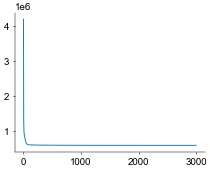

In [320]:
plt.plot(training_loss)

### Cross-validation

In [323]:
cvs = [1, 2, 3, 5, 6, 8]
batch_info = 500

config_names = [
    'th1_U-el-1_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-el-2_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-el-3_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-el-4_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-eq-3_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
]


Ell = []
for name in config_names:
    full_model, training_loss, fit_dict, val_dict = models.load_model(
        name,
        checkpoint_dir,
        dataset_dict,
        batch_info,
        device,
    )
    
    Ell.append(
        models.RG_pred_ll(
            full_model,
            val_dict,
            neuron_group=None,
            ll_mode="GH",
            ll_samples=100,
            cov_samples=1,
            beta=0.0,
        )
    )
    
Ell = np.array(Ell).reshape(-1, len(cvs))

FileNotFoundError: [Errno 2] No such file or directory: '../scripts/checkpoint/th1_U-el-1_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f6.pt'

<ErrorbarContainer object of 3 artists>

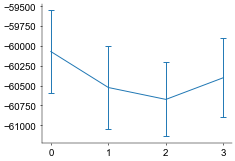

In [322]:
plt.errorbar(np.arange(Ell.shape[0]), Ell.mean(-1), yerr=Ell.std(-1) / np.sqrt(len(cvs)), capsize=3)

In [257]:
class _bumps:
    @staticmethod
    def HDC_bumps(theta, A, invbeta, b, theta_0):
        """
        parameters have shape (neurons,)
        :return:
            rates of shape (..., neurons, eval_pts)
        """
        return A[:, None] * np.exp(
            np.cos(theta[..., None, :] - theta_0[:, None]) / invbeta[:, None]) + b[:, None]

    
class hCMP_bumps(_bumps):
    """
    CMP with separate mu and nu parameter tuning curves
    """
    def __init__(self, rng, neurons):
        # rate tuning curves
        self.angle_0 = np.linspace(0, 2 * np.pi, neurons + 1)[:-1]
        self.beta = rng.uniform(size=(neurons,)) * 2.0 + 0.5
        self.rate_0 = rng.uniform(size=(neurons,)) * 4.0 + 4.0
        self.b = rng.uniform(size=(neurons,)) * 0.1

        # dispersion tuning curve
        self._angle_0 = rng.permutation(self.angle_0)
        self._beta = 0.3 * rng.uniform(size=(neurons,)) + 0.1
        self._rate_0 = rng.uniform(size=(neurons,)) * 0.5 + 0.6
        self._b = rng.uniform(size=(neurons,)) * 0.1
        
    def __call__(self, covariates, sample_bin):
        theta = covariates[..., 0]
        mu = _bumps.HDC_bumps(theta, self.rate_0, 1/self.beta, self.b, self.angle_0)
        nu = _bumps.HDC_bumps(theta, self._rate_0, 1/self._beta, self._b, self._angle_0)
        
        lamb = np.maximum(mu*sample_bin + .5 * (1 - 1/nu), 0.)**(nu)  # threshold as expression is approximate
        return lamb, nu  # (..., neurons, ts)

In [258]:
m = hCMP_bumps(rng, 50)

In [259]:
lamb, nu = m(np.linspace(0., 2*np.pi, 100)[:, None], 0.1)

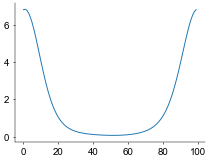

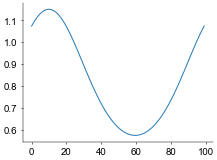

In [260]:
plt.plot(lamb[0, :])
plt.show()

plt.plot(nu[3, :])
plt.show()

In [316]:
data_path = '../data/'
data_type = 'hCMP1'
bin_size = 1

dataset_dict = models.get_dataset(data_type, bin_size, data_path)


### IP

In [ ]:
datatype = 1
rcov, neurons, tbin, resamples, rc_t = validation.get_dataset(datatype, '../scripts/data')
max_count = int(rc_t.max())
trials = 1

use_neuron = np.arange(50)


rhd_t = rcov[0]
ra_t = rcov[1]
covariates = [rhd_t[None, :, None].repeat(trials, axis=0), 
              ra_t[None, :, None].repeat(trials, axis=0)]
glm = validation.IP_bumps(tbin, resamples, covariates, neurons, trials=trials)
glm.to(dev)

checkpoint = torch.load('../scripts/data/IP_HDC_model', map_location='cuda:0')
glm.load_state_dict(checkpoint['model'])

In [ ]:
modes = [('GP', 'IP', 'hd', 8, 'exp', 1, [], False, 10, False, 'ew'), 
         ('GP', 'U', 'hd', 8, 'identity', 3, [], False, 10, False, 'ew'),
         ('GP', 'U', 'hdxR1', 16, 'identity', 3, [1], False, 10, False, 'ew')]

In [ ]:
# neuron subgroup likelihood CV
beta = 0.0
n_group = np.arange(5)
val_neuron = [n_group, n_group+10, n_group+20, n_group+30, n_group+40]
ncvx = 2
kcvs = [2, 5, 8] # validation sets chosen in 10-fold split of data
Ms = modes[:3]

batch_size = 5000
cv_pll = []
for em, mode in enumerate(Ms):
    for cvdata in model_utils.get_cv_sets(mode, kcvs, batch_size, rc_t, resamples, rcov):
        _, ftrain, fcov, vtrain, vcov, cvbatch_size = cvdata
        cv_set = (ftrain, fcov, vtrain, vcov)
        
        if em > 1:
            for v_neuron in val_neuron:

                prev_ll = np.inf
                for tr in range(ncvx):
                    full_model = get_full_model(datatype, cvdata, resamples, rc_t, 100, 
                                                mode, rcov, max_count, neurons)
                    mask = np.ones((neurons,), dtype=bool)
                    mask[v_neuron] = False
                    f_neuron = np.arange(neurons)[mask]
                    ll = model_utils.LVM_pred_ll(full_model, mode[-5], mode[2], models.cov_used, cv_set, f_neuron, v_neuron, 
                                                 beta=beta, beta_z=0.0, max_iters=3000)[0]
                    if ll < prev_ll:
                        prev_ll = ll

                cv_pll.append(prev_ll)
                
        else:
            for v_neuron in val_neuron:
                full_model = get_full_model(datatype, cvdata, resamples, rc_t, 100, 
                                            mode, rcov, max_count, neurons)
                cv_pll.append(model_utils.RG_pred_ll(full_model, mode[2], models.cov_used, cv_set, bound='ELBO', 
                                                     beta=beta, neuron_group=v_neuron, ll_mode='GH', ll_samples=100))

        
cv_pll = np.array(cv_pll).reshape(len(Ms), len(kcvs), len(val_neuron))

In [ ]:
# compute tuning curves and latent trajectories for XZ joint regression-latent model
mode = modes[2]
cvdata = model_utils.get_cv_sets(mode, [-1], 5000, rc_t, resamples, rcov)[0]

full_model = get_full_model(datatype, cvdata, resamples, rc_t, 100, 
                            mode, rcov, max_count, neurons)

# latents
X_loc, X_std = full_model.inputs.eval_XZ()

T = X_loc[1].shape[0]
X_c, shift, sign, scale, _ = utils.latent.signed_scaled_shift(X_loc[1], ra_t[:T], 
                                                              dev, 'euclid', learn_scale=True)
X_s = scale*X_std[1]



# tuning
steps = 100
covariates_z = [0.*np.ones(steps), np.linspace(X_loc[1].min(), X_loc[1].max(), steps)]
P_mc = model_utils.compute_P(full_model, covariates_z, use_neuron, MC=1000).cpu()

x_counts = torch.arange(max_count+1)
avg = (x_counts[None, None, None, :]*P_mc).sum(-1)
xcvar = ((x_counts[None, None, None, :]**2*P_mc).sum(-1)-avg**2)
ff = xcvar/avg

avgs = utils.signal.percentiles_from_samples(avg, percentiles=[0.05, 0.5, 0.95], 
                                             smooth_length=5, padding_mode='replicate')
avglower, avgmean, avgupper = [cs_.cpu().numpy() for cs_ in avgs]

ffs = utils.signal.percentiles_from_samples(ff, percentiles=[0.05, 0.5, 0.95], 
                                            smooth_length=5, padding_mode='replicate')
fflower, ffmean, ffupper = [cs_.cpu().numpy() for cs_ in ffs]


covariates_z[1] = sign*scale*covariates_z[1]+shift
grate = glm.mapping.eval_rate(covariates_z, use_neuron)[0, ...]
gFF = np.ones_like(grate)

In [ ]:
# KS framework
Qq = []
Zz = []
R = []
Rp = []

batch_size = 5000

Ms = modes[:3]
CV = [2, 5, 8]
for kcv in CV:
    for en, mode in enumerate(Ms):
        cvdata = model_utils.get_cv_sets(mode, [kcv], batch_size, rc_t, resamples, rcov)[0]
        _, ftrain, fcov, vtrain, vcov, cvbatch_size = cvdata
        time_steps = ftrain.shape[-1]
            
        full_model = get_full_model(datatype, cvdata, resamples, rc_t, 100, 
                                    mode, rcov, max_count, neurons)

        if en > 0:
            # predictive posterior
            q_ = []
            Z_ = []
            for b in range(full_model.inputs.batches):
                P_mc = model_utils.compute_pred_P(full_model, b, use_neuron, None, cov_samples=10, ll_samples=1, tr=0)
                P = P_mc.mean(0).cpu().numpy()

                for n in range(len(use_neuron)):
                    spike_binned = full_model.likelihood.spikes[b][0, n, :].numpy()
                    q, Z = model_utils.get_q_Z(P[n, ...], spike_binned, deq_noise=None)

                    if b == 0:
                        q_.append(q)
                        Z_.append(Z)
                    else:
                        q_[n] = np.concatenate((q_[n], q))
                        Z_[n] = np.concatenate((Z_[n], Z))

        elif en == 0:
            cov_used = models.cov_used(mode[2], fcov)
            q_ = model_utils.compute_count_stats(full_model, 'IP', tbin, ftrain, cov_used, use_neuron, \
                                                 traj_len=1, start=0, T=time_steps, bs=5000)
            Z_ = [utils.stats.q_to_Z(q) for q in q_]


        Pearson_s = []
        for n in range(len(use_neuron)):
            for m in range(n+1, len(use_neuron)):
                r, r_p = scstats.pearsonr(Z_[n], Z_[m]) # Pearson r correlation test
                Pearson_s.append((r, r_p))

        r = np.array([p[0] for p in Pearson_s])
        r_p = np.array([p[1] for p in Pearson_s])

        Qq.append(q_)
        Zz.append(Z_)
        R.append(r)
        Rp.append(r_p)

    
    
fisher_z = []
fisher_q = []
for en, r in enumerate(R):
    fz = 0.5*np.log((1+r)/(1-r))*np.sqrt(time_steps-3)
    fisher_z.append(fz)
    fisher_q.append(utils.stats.Z_to_q(fz))
    
    
    
q_DS_ = []
T_DS_ = []
T_KS_ = []
for q in Qq:
    for qq in q:
        T_DS, T_KS, sign_DS, sign_KS, p_DS, p_KS = utils.stats.KS_statistics(qq, alpha=0.05, alpha_s=0.05)
        T_DS_.append(T_DS)
        T_KS_.append(T_KS)
        
        Z_DS = T_DS/np.sqrt(2/(qq.shape[0]-1))
        q_DS_.append(utils.stats.Z_to_q(Z_DS))


q_DS_ = np.array(q_DS_).reshape(len(CV), len(Ms), -1)
T_DS_ = np.array(T_DS_).reshape(len(CV), len(Ms), -1)
T_KS_ = np.array(T_KS_).reshape(len(CV), len(Ms), -1)

In [ ]:
# noise correlation structure
NN = len(use_neuron)
R_mat_Xp = np.zeros((NN, NN))
R_mat_X = np.zeros((NN, NN))
R_mat_XZ = np.zeros((NN, NN))
for a in range(len(R[0])):
    n, m = model_utils.ind_to_pair(a, NN)
    R_mat_Xp[n, m] = R[0][a]
    R_mat_X[n, m] = R[1][a]
    R_mat_XZ[n, m] = R[2][a]

In [ ]:
data_run = (
    q_DS_, T_DS_, T_KS_, sign_DS, fisher_z, fisher_q, Qq, Zz, 
    R, Rp, X_c, X_s, ra_t, R_mat_Xp, R_mat_X, R_mat_XZ, cv_pll, 
    covariates_z, avglower, avgmean, avgupper, fflower, ffmean, ffupper, 
    grate, gFF, 
    use_neuron, max_count, tbin, rcov
)

pickle.dump(data_run, open('./saves/P2.p', 'wb'))

### hCMP

In [ ]:
modes = [('GP', 'IP', 'hd', 8, 'exp', 1, [], False, 10, False, 'ew'), 
         ('GP', 'hNB', 'hd', 8, 'exp', 1, [], False, 10, False, 'ew'), 
         ('GP', 'U', 'hd', 8, 'identity', 3, [], False, 10, False, 'ew'), 
         ('ANN', 'U', 'hd', 8, 'identity', 3, [], False, 10, False, 'ew'), 
         ('GP', 'IP', 'T1', 8, 'exp', 1, [0], False, 10, False, 'ew'), 
         ('GP', 'hNB', 'T1', 8, 'exp', 1, [0], False, 10, False, 'ew'), 
         ('GP', 'U', 'T1', 8, 'identity', 3, [0], False, 10, False, 'ew'), 
         ('ANN', 'U', 'T1', 8, 'identity', 3, [0], False, 10, False, 'ew')]

In [ ]:
datatype = 0
rcov, neurons, tbin, resamples, rc_t = validation.get_dataset(datatype, '../scripts/data')
max_count = int(rc_t.max())

use_neuron = list(range(neurons))


rhd_t = rcov[0]
trials = 1
covariates = [rhd_t[None, :, None].repeat(trials, axis=0)]
glm = validation.CMP_hdc(tbin, resamples, covariates, neurons, trials=trials)
glm.to(dev)

checkpoint = torch.load('../scripts/data/hCMP_HDC_model', map_location='cpu')

glm.load_state_dict(checkpoint['model'])

In [ ]:
# cross-validation of regression models
beta = 0.0
kcvs = [2, 5, 8] # validation sets chosen in 10-fold split of data
batch_size = 5000

Ms = modes[:4]
RG_cv_ll = []
for mode in Ms:
    for cvdata in model_utils.get_cv_sets(mode, kcvs, batch_size, rc_t, resamples, rcov):
        _, ftrain, fcov, vtrain, vcov, cvbatch_size = cvdata
        cv_set = (ftrain, fcov, vtrain, vcov)
        
        full_model = get_full_model(datatype, cvdata, resamples, rc_t, 100, 
                                    mode, rcov, max_count, neurons)
        RG_cv_ll.append(model_utils.RG_pred_ll(full_model, mode[2], models.cov_used, cv_set, bound='ELBO', 
                                               beta=beta, neuron_group=None, ll_mode='GH', ll_samples=100))
    
RG_cv_ll = np.array(RG_cv_ll).reshape(len(Ms), len(kcvs))

In [ ]:
# compute tuning curves of ground truth model
batch_size = 5000

cvdata = model_utils.get_cv_sets(mode, [2], batch_size, rc_t, resamples, rcov)[0]
full_model = get_full_model(datatype, cvdata, resamples, rc_t, 100, 
                            modes[2], rcov, max_count, neurons)



steps = 100
covariates = [np.linspace(0, 2*np.pi, steps)]
P_mc = model_utils.compute_P(full_model, covariates, use_neuron, MC=1000)
P_rg = P_mc.mean(0).cpu().numpy()

x_counts = torch.arange(max_count+1)



mu = glm.mapping.eval_rate(covariates, use_neuron)[0:1, ...] # mu is the rate, so need to multiply by tbin
log_nu = glm.likelihood.dispersion_mapping.eval_rate(covariates, use_neuron)[0:1, ...]

log_mudt = torch.tensor(np.log(mu*tbin)).to(dev)
nu = torch.tensor(np.exp(log_nu)).to(dev)

AD = False # using Autograd for computing the CMP partition function is slow...
if AD: # differentiate the partition function
    t = torch.tensor(0.).to(dev)
    t.requires_grad = True
    log_Z = glm.likelihood.log_Z(log_mu+t, nu)

    grad_t = torch.empty(log_Z.shape)
    ggrad_t = torch.empty(log_Z.shape)
    for n in use_neuron:
        print(n)
        for s in range(steps):
            ind = torch.zeros_like(log_Z)
            ind[0, n, s] = 1.
            grad_t_, = torch.autograd.grad(log_Z, t, ind, retain_graph=True, create_graph=True)
            grad_t[0, n, s] = grad_t_

            ggrad_t_, = torch.autograd.grad(grad_t_, t, retain_graph=True, create_graph=True)
            ggrad_t[0, n, s] = ggrad_t_


    gmean = grad_t.data.cpu().numpy()[0, ...]
    gvar = ggrad_t.data.cpu().numpy()[0, ...]

else: # compute the partition function explicitly
    gmean = utils.stats.cmp_moments(1, mu[0, ...], nu.cpu().numpy()[0, ...], tbin, J=10000)
    gvar = utils.stats.cmp_moments(2, mu[0, ...], nu.cpu().numpy()[0, ...], tbin, J=10000) - gmean**2
    
grate = mu[0, ...]
gdisp = nu.cpu().numpy()[0, ...]
gFF = gvar/gmean



# compute tuning curves and SCDs for model fit
ref_prob = []
hd = [20, 50, 80]
for hd_ in hd:
    for n in range(len(use_neuron)):
        ref_prob.append([utils.stats.cmp_count_prob(xc, grate[n, hd_], gdisp[n, hd_], tbin) for xc in x_counts.numpy()])
ref_prob = np.array(ref_prob).reshape(len(hd), len(use_neuron), -1)

cs = utils.signal.percentiles_from_samples(P_mc[..., hd, :], percentiles=[0.05, 0.5, 0.95], smooth_length=1)
clower, cmean, cupper = [cs_.cpu().numpy() for cs_ in cs]


avg = (x_counts[None, None, None, :]*P_mc.cpu()).sum(-1)
xcvar = ((x_counts[None, None, None, :]**2*P_mc.cpu()).sum(-1)-avg**2)
ff = xcvar/avg

avgs = utils.signal.percentiles_from_samples(avg, percentiles=[0.05, 0.5, 0.95], 
                                             smooth_length=5, padding_mode='circular')
avglower, avgmean, avgupper = [cs_.cpu().numpy() for cs_ in avgs]

ffs = utils.signal.percentiles_from_samples(ff, percentiles=[0.05, 0.5, 0.95], 
                                            smooth_length=5, padding_mode='circular')
fflower, ffmean, ffupper = [cs_.cpu().numpy() for cs_ in ffs]

xcvars = utils.signal.percentiles_from_samples(xcvar, percentiles=[0.05, 0.5, 0.95], 
                                               smooth_length=5, padding_mode='circular')
varlower, varmean, varupper = [cs_.cpu().numpy() for cs_ in xcvars]

In [ ]:
# KS framework
Qq_rg = []
Zz_rg = []

batch_size = 5000
M = modes[:4]
CV = [2, 5, 8]
for kcv in CV:
    for en, mode in enumerate(M):
        cvdata = model_utils.get_cv_sets(mode, [kcv], batch_size, rc_t, resamples, rcov)[0]
        full_model = get_full_model(datatype, cvdata, resamples, rc_t, 100, 
                                    mode, rcov, max_count, neurons)

        if en > 1:
            # predictive posterior
            P_mc = model_utils.compute_pred_P(full_model, 0, use_neuron, None, cov_samples=10, ll_samples=1, tr=0)
            P = P_mc.mean(0).cpu().numpy()

            q_ = []
            Z_ = []
            for n in range(len(use_neuron)):
                spike_binned = full_model.likelihood.spikes[0][0, use_neuron[n], :].numpy()
                q, Z = model_utils.get_q_Z(P[n, ...], spike_binned, deq_noise=None)
                q_.append(q)
                Z_.append(Z)

        elif en < 2:
            _, ftrain, fcov, vtrain, vcov, cvbatch_size = cvdata
            time_steps = ftrain.shape[-1]

            cov_used = models.cov_used(mode[2], fcov)
            q_ = model_utils.compute_count_stats(full_model, mode[1], tbin, ftrain, cov_used, list(range(neurons)), \
                                                 traj_len=1, start=0, T=time_steps, bs=5000)
            Z_ = [utils.stats.q_to_Z(q) for q in q_]

        Qq_rg.append(q_)
        Zz_rg.append(Z_)

    
q_DS_rg = []
T_DS_rg = []
T_KS_rg = []
for q in Qq_rg:
    for qq in q:
        T_DS, T_KS, sign_DS, sign_KS, p_DS, p_KS = utils.stats.KS_statistics(qq, alpha=0.05, alpha_s=0.05)
        T_DS_rg.append(T_DS)
        T_KS_rg.append(T_KS)
        
        Z_DS = T_DS/np.sqrt(2/(qq.shape[0]-1))
        q_DS_rg.append(utils.stats.Z_to_q(Z_DS))

q_DS_rg = np.array(q_DS_rg).reshape(len(CV), len(M), -1)
T_DS_rg = np.array(T_DS_rg).reshape(len(CV), len(M), -1)
T_KS_rg = np.array(T_KS_rg).reshape(len(CV), len(M), -1)

In [ ]:
# aligning trajectory and computing RMS for different models
topology = 'torus'
cvK = 90
CV = [15, 30, 45, 60, 75]
Modes = modes[4:8]
batch_size = 5000

RMS_cv = []
for mode in Modes:
    cvdata = model_utils.get_cv_sets(mode, [-1], batch_size, rc_t, resamples, rcov)[0]
    full_model = get_full_model(datatype, cvdata, resamples, rc_t, 100, 
                                mode, rcov, max_count, neurons)

    X_loc, X_std = full_model.inputs.eval_XZ()
    cvT = X_loc[0].shape[0]
    tar_t = rhd_t[:cvT]
    lat = X_loc[0]
    
    for rn in CV:
        eval_range = np.arange(cvT//cvK) + rn*cvT//cvK

        _, shift, sign, _, _ = utils.latent.signed_scaled_shift(lat[eval_range], tar_t[eval_range], 
                                                                topology=topology, dev=dev, learn_scale=False)
        
        mask = np.ones((cvT,), dtype=bool)
        mask[eval_range] = False
        
        lat_t = torch.tensor((sign*lat+shift) % (2*np.pi))
        D = (utils.latent.metric(torch.tensor(tar_t)[mask], lat_t[mask], topology)**2)
        RMS_cv.append(np.sqrt(D.mean().item()))


RMS_cv = np.array(RMS_cv).reshape(len(Modes), len(CV))

In [ ]:
# neuron subgroup likelihood CV for latent models
beta = 0.0
n_group = np.arange(5)
ncvx = 2
kcvs = [2, 5, 8] # validation sets chosen in 10-fold split of data
Ms = modes[4:8]
val_neuron = [n_group, n_group+10, n_group+20, n_group+30, n_group+40]

batch_size = 5000
LVM_cv_ll = []
for kcv in kcvs:
    for mode in Ms:
        cvdata = model_utils.get_cv_sets(mode, [kcv], batch_size, rc_t, resamples, rcov)[0]
        _, ftrain, fcov, vtrain, vcov, cvbatch_size = cvdata
        cv_set = (ftrain, fcov, vtrain, vcov)
        
        for v_neuron in val_neuron:

            prev_ll = np.inf
            for tr in range(ncvx):
                full_model = get_full_model(datatype, cvdata, resamples, rc_t, 100, 
                                            mode, rcov, max_count, neurons)
                mask = np.ones((neurons,), dtype=bool)
                mask[v_neuron] = False
                f_neuron = np.arange(neurons)[mask]
                ll = model_utils.LVM_pred_ll(full_model, mode[-5], mode[2], models.cov_used, cv_set, f_neuron, v_neuron, 
                                             beta=beta, beta_z=0.0, max_iters=3000)[0]
                if ll < prev_ll:
                    prev_ll = ll

            LVM_cv_ll.append(prev_ll)
        
LVM_cv_ll = np.array(LVM_cv_ll).reshape(len(kcvs), len(Ms), len(val_neuron))

In [ ]:
# compute tuning curves and latent trajectory of latent Universal model
lat_t_ = []
lat_std_ = []
P_ = []

comp_grate = []
comp_gdisp = []
comp_gFF = []
comp_gvar = []

comp_avg = []
comp_ff = []
comp_var = []

for mode in modes[-2:]:
    cvdata = model_utils.get_cv_sets(mode, [-1], 5000, rc_t, resamples, rcov)[0]
    full_model = get_full_model(datatype, cvdata, resamples, rc_t, 100, 
                                mode, rcov, max_count, neurons)

    # predict latents
    X_loc, X_std = full_model.inputs.eval_XZ()
    cvT = X_loc[0].shape[0]

    lat_t, shift, sign, _, _ = utils.latent.signed_scaled_shift(X_loc[0], rhd_t[:cvT], 
                                                             dev, learn_scale=False)
    lat_t_.append(utils.signal.WrapPi(lat_t, True))
    lat_std_.append(X_std[0])

    # P
    steps = 100
    covariates_aligned = [(sign*(np.linspace(0, 2*np.pi, steps)-shift)) % (2*np.pi)]
    P_mc = model_utils.compute_P(full_model, covariates_aligned, use_neuron, MC=1000).cpu()

    x_counts = torch.arange(max_count+1)
    avg = (x_counts[None, None, None, :]*P_mc).sum(-1)
    xcvar = ((x_counts[None, None, None, :]**2*P_mc).sum(-1)-avg**2)
    ff = xcvar/avg

    avgs = utils.signal.percentiles_from_samples(avg, percentiles=[0.05, 0.5, 0.95], 
                                                 smooth_length=5, padding_mode='circular')
    comp_avg.append([cs_.cpu().numpy() for cs_ in avgs])

    ffs = utils.signal.percentiles_from_samples(ff, percentiles=[0.05, 0.5, 0.95], 
                                                smooth_length=5, padding_mode='circular')
    comp_ff.append([cs_.cpu().numpy() for cs_ in ffs])

In [ ]:
data_run = (
    use_neuron, covariates, P_rg, grate, gdisp, gFF, gvar, hd, ref_prob, clower, cmean, cupper, 
    avglower, avgmean, avgupper, fflower, ffmean, ffupper, varlower, varmean, varupper, 
    covariates_aligned, lat_t_, lat_std_, comp_avg, comp_ff, 
    RG_cv_ll, LVM_cv_ll, RMS_cv, 
    q_DS_rg, T_DS_rg, T_KS_rg, Qq_rg, Zz_rg, sign_DS, sign_KS, 
    max_count, tbin, rcov
)

pickle.dump(data_run, open('./saves/P1_hcmp.p', 'wb'))